In [1]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
from tqdm.autonotebook import tqdm
import os
import time
import pandas as pd
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage import io
import inspect
from torch.utils.data import (
    Dataset,
    DataLoader,
) 
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive', force_remount=True)
path='/content/drive/MyDrive/MSCS/deep_learning_project/'

Mounted at /content/drive


### Method to create csv file with image classes

In [ ]:
"""import csv

with open(f'{path}dataset1/known_image_classes.csv', mode='w') as class_file:
    class_writer = csv.writer(class_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    class_writer.writerow(['patient', 'class(normal=0, sick=1)'])
    for img in onlyfiles:
      if img.startswith("normal"):
        class_writer.writerow([img, 0])
      elif img.startswith("sick"):
        class_writer.writerow([img, 1])"""

'import csv\n\nwith open(f\'{path}dataset1/known_image_classes.csv\', mode=\'w\') as class_file:\n    class_writer = csv.writer(class_file, delimiter=\',\', quotechar=\'"\', quoting=csv.QUOTE_MINIMAL)\n\n    class_writer.writerow([\'patient\', \'class(normal=0, sick=1)\'])\n    for img in onlyfiles:\n      if img.startswith("normal"):\n        class_writer.writerow([img, 0])\n      elif img.startswith("sick"):\n        class_writer.writerow([img, 1])'

In [ ]:
#train_datast = Dataset.ImageFolder(root=f'{path}dataset1/known_images', transform=transforms)


### Define Dataset

In [4]:
class ChestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        filename = self.annotations.iloc[index, 0]

        if self.transform:
            image = self.transform(image)
            image = torch.unsqueeze(image, 0)



        return (image, y_label, filename)

### Preprocessing data 

In [5]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
  ])

In [6]:
dataset = ChestDataset(
    csv_file=f'{path}dataset1/known_image_classes.csv',
    root_dir=f'{path}dataset1/known_images',
    transform=preprocess,
)

In [7]:
dtsize = len(dataset)
dtsize

715

Function for defining train_test split ratio

In [8]:
def splitdt(dtsize, n1, n2):
  tt=n1+n2
  d1=int((n1/tt)*dtsize)
  d2=int((n2/tt)*dtsize)
  return [d1, d2]


Dataset is split into Training and Test data

In [24]:
train_set, test_set = torch.utils.data.random_split(dataset, splitdt(dtsize, 60,40))
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)

In [10]:
def imshow(img):
   npimg = img.numpy() #convert the tensor to numpy for displaying the image
   #for displaying the image, shape of the image should be height * width * channels 
   plt.imshow(np.transpose(npimg, (1, 2, 0))) 
   plt.show()

In [11]:
images= next(iter(test_loader)) 

print("images-size:", images[0].shape)
print("images-size:", images[0].squeeze(1).shape)


images-size: torch.Size([16, 1, 1, 224, 224])
images-size: torch.Size([16, 1, 224, 224])


Display sample of the chest images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


out-size: torch.Size([3, 454, 1810])


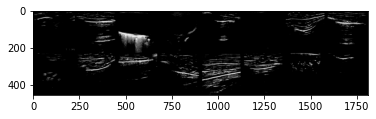

In [12]:
out = torchvision.utils.make_grid(images[0].squeeze(1))
print("out-size:", out.shape)
imshow(out)

Define the device in which the model will be run

In [13]:
#Select device cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Defining the model to accept grayscale images:

We use ResNet-18 model to classify the images.
*   Model Parameters like the kernel size were adjusted to accomodate the data .
*   The model was defined to accomodate grayscale images by reducing the number of input channels to 1 and output 2 classes in the output layer




In [25]:
# Model
class ChestResNet(nn.Module):
  def __init__(self, in_channels=1, kernel_size=224):
    super(ChestResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = torchvision.models.resnet18(pretrained=True)

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=kernel_size, stride=2, padding=3, bias=False)
    #self.model.bn1 = nn.BatchNorm2d(16)
    
    # Change the output layer to output 2 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 2)

  def forward(self, x):
    return self.model(x)


model = ChestResNet()

model.to(device)

ChestResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(224, 224), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Calculate Loss using Cross Entropy loss  


In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
len(train_loader)

27

Function to calculate accuracy

In [17]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print( f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

Define hyperparameters

In [18]:
learning_rate = 0.0001
num_epochs = 5

Training the Network

In [ ]:

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


start_ts = time.time()
epoches=[]
losses = []
accuracies=[]
precisions=[]
recalls=[]
f1_scores=[]
batches=len(train_loader)
val_batches=len(test_loader)
for epoch in range(num_epochs):
    
    total_loss = 0
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
    model.train()
    for batch_idx, sample in progress:
        # Get data to cuda if possible
        data, targets = sample[0], sample[1]
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data.squeeze(1))
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent 
        optimizer.step()

        #losses.append(loss.item())
        current_loss = loss.item()
        total_loss += current_loss


        

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(batch_idx+1)))
      

    #print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            # Get data to cuda if possible
            data, targets = sample[0], sample[1]
            X = data.to(device=device)
            y = targets.to(device=device)

            outputs = model(X.squeeze(1)) # this get's the prediction from the network

            val_losses += criterion(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{num_epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
print(f"Training time: {time.time()-start_ts}s")



Loss:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/5, training loss: 0.702792763710022, validation loss: 0.6860439777374268
	     precision: 0.4971
	        recall: 1.0000
	            F1: 0.6584
	      accuracy: 0.5112


Loss:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/5, training loss: 0.3845598953110831, validation loss: 0.5434306859970093
	     precision: 0.7003
	        recall: 0.9265
	            F1: 0.7970
	      accuracy: 0.7596


Loss:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/5, training loss: 0.2938739061355591, validation loss: 0.5313131213188171
	     precision: 0.8663
	        recall: 0.7004
	            F1: 0.7662
	      accuracy: 0.7948


Loss:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/5, training loss: 0.26722922921180725, validation loss: 0.46767204999923706
	     precision: 0.8398
	        recall: 0.8406
	            F1: 0.8392
	      accuracy: 0.8354


Loss:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/5, training loss: 0.21559526664870127, validation loss: 0.37081989645957947
	     precision: 0.8749
	        recall: 0.8874
	            F1: 0.8802
	      accuracy: 0.8756
Training time: 351.4382269382477s


In [ ]:
accuracies


[[0.546875, 0.546875, 0.6666666666666666],
 [0.65625, 0.71875, 0.5333333333333333],
 [0.734375, 0.765625, 0.8],
 [0.796875, 0.859375, 0.8],
 [0.796875, 0.859375, 0.8],
 [0.90625, 0.953125, 0.9333333333333333],
 [0.875, 0.96875, 0.8666666666666667],
 [0.9375, 0.96875, 0.8],
 [0.859375, 0.953125, 1.0],
 [0.90625, 0.9375, 1.0]]

## Saving Model

In [26]:
torch.save(model.state_dict(), f'{path}dataset1/model4')

### Loading saved model

In [32]:
# Model
class ChestResNet_mod(nn.Module):
  def __init__(self, in_channels=1, kernel_size=224,pretrained=False):
    super(ChestResNet_mod, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = torchvision.models.resnet18(pretrained=pretrained)

    # Change the input layer to take Grayscale image, instead of RGB images. 
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=kernel_size, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 2 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 2)

  def forward(self, x):
    return self.model(x)


In [33]:
model1 = ChestResNet_mod() # we do not specify pretrained=True, i.e. do not load default weights
model1.load_state_dict(torch.load(f'{path}dataset1/model4'))
model1.eval()

ChestResNet_mod(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(224, 224), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

PREDICTING UNKNOWN DATASETS UNDER DATASET1





In [34]:
class UnknownDataset(Dataset):
    def __init__(self,  root_dir, transform=None):
        #self.annotations = pd.read_csv(csv_file)
        self.annotations = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations[index])
        image = Image.open(img_path)
        #y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        filename = self.annotations[index]

        if self.transform:
            image = self.transform(image)
            #image = torch.unsqueeze(image, 0)



        return (image, filename)

In [35]:
unknown_dataset = UnknownDataset(
    root_dir=f'{path}dataset1/unknown_images',
    transform=preprocess,
)

In [40]:
unknown_loader = DataLoader(dataset=unknown_dataset, batch_size=50, shuffle=True)

In [39]:
len(unknown_dataset)

50

## PREDICTING AND SAVING DATA CLASSIFICATION INTO CSV FILE

In [41]:

import csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


with open(f'{path}dataset1/unknown_image_classification.csv', mode='w') as class_file:
    class_writer = csv.writer(class_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    class_writer.writerow(['Name', 'Hilary Kansiime'])
    class_writer.writerow(['Registration Number', '2020/HD05/17691U'])
    class_writer.writerow(['patient', 'class(normal=0, sick=1)'])
    '''for img in onlyfiles:
      if img.startswith("normal"):
        class_writer.writerow([img, 0])
      elif img.startswith("sick"):
        class_writer.writerow([img, 1])'''

    with torch.no_grad():
      for batch_idx, (data, img) in enumerate(unknown_loader):
        # Get data to cuda if possible
        X = data.to(device=device)
        y = img
        outputs = model1(X) # this get's the prediction from the network
        #print(f'{len(y)}==>{torch.max(outputs, 1)[1]}')
        
        
        for (i , s) in zip(y, torch.max(outputs, 1)[1]):
          print(f'{i}==>{s}')
          class_writer.writerow([i, s.numpy()])
          

        
        break
    #print(f'{torch.max(outputs, 1)[1]}')
    
    

8.png==>1
20.png==>1
3.png==>0
26.png==>1
32.png==>1
5.png==>0
7.png==>0
45.png==>0
36.png==>1
46.png==>1
35.png==>0
23.png==>0
15.png==>0
17.png==>0
4.png==>1
29.png==>0
47.png==>0
2.png==>1
37.png==>0
28.png==>1
34.png==>1
38.png==>1
27.png==>1
25.png==>0
24.png==>1
12.png==>1
42.png==>1
44.png==>1
16.png==>1
43.png==>0
14.png==>1
33.png==>0
1.png==>1
31.png==>0
6.png==>1
39.png==>0
19.png==>0
9.png==>0
18.png==>1
41.png==>0
50.png==>0
40.png==>1
21.png==>0
49.png==>0
10.png==>1
13.png==>0
11.png==>0
22.png==>1
48.png==>1
30.png==>1


# EVALUATING TRAINED MODEL WITH DATASET 2

Define Dataset

In [42]:
dataset2 = ChestDataset(
    csv_file=f'{path}dataset2/image_classes.csv',
    root_dir=f'{path}dataset2/images',
    transform=preprocess,
)
dataset3 = ChestDataset(
    csv_file=f'{path}dataset2/image_classes1.csv',
    root_dir=f'{path}dataset2/images',
    transform=preprocess,
)

In [49]:
eval_loader = DataLoader(dataset=dataset2, batch_size=8, shuffle=True)

224

Evaluate model

In [50]:
eval_batches=len(eval_loader)
# ----------------- Evaluation  ----------------- 
eval_losses = 0
precision_eval, recall_eval, f1_eval, accuracy_eval = [], [], [], []
    
# set model to evaluating (testing)
loader_data = tqdm(enumerate(eval_loader), desc="Loss: ", total=eval_batches)
with torch.no_grad():
  for batch_idx, sample in loader_data:
    # Get data to cuda if possible
    data, targets = sample[0], sample[1]
    X = data.to(device=device)
    y = targets.to(device=device)

    outputs = model1(X.squeeze(1)) # this get's the prediction from the network

    eval_losses += criterion(outputs, y)

    predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
    # updating progress bar
    progress.set_description("Loss: {:.4f}".format(total_loss/(batch_idx+1)))
            
    # calculate P/R/F1/A metrics for batch
    for acc, metric in zip((precision_eval, recall_eval, f1_eval, accuracy_eval), 
                           (precision_score, recall_score, f1_score, accuracy_score)):
      acc.append(
          calculate_metric(metric, y.cpu(), predicted_classes.cpu())
          )

Loss:   0%|          | 0/28 [00:00<?, ?it/s]

In [51]:
print_scores(precision_eval, recall_eval, f1_eval, accuracy_eval, eval_batches)

	     precision: 0.4753
	        recall: 0.8893
	            F1: 0.5997
	      accuracy: 0.4598


Saving results into text file

In [ ]:
with open(f'{path}dataset2/results_dataset2.txt', 'w') as f:
    f.write('Name: Hilary Kansiime\n')
    f.write('Registration Number: 2020/HD05/17691U \n')
    f.write('##########RESULTS FROM DATASET2################\n')
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (precision_eval, recall_eval, f1_eval, accuracy_eval)):
        f.write( f"\t{name.rjust(14, ' ')}: {sum(scores)/eval_batches:.4f}\n")
    f.write('################################################')
